In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
import catboost as catb
import lightgbm as lgb

from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model
from utils import calc_pot_temp

# Define constants

In [3]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Read ERA data

In [61]:
df_ERA_raw = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_North_Foehn_Piotta_data.csv.gz", parse_dates=["date"])

In [62]:
#df_ERA = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz", parse_dates=["date"])
# df_ERA["date"] = pd.to_datetime(df_ERA["date"], format="%Y-%m-%dT%H:%M:00.000Z") # Only if reading from Dataiku file
df_ERA_raw.dropna(inplace=True)
df_ERA_raw.reset_index(inplace=True, drop=True)

In [106]:
df_ERA = df_ERA_raw.copy()

# Load CESM data 

In [174]:
df_CESMp = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [175]:
df_CESMf = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [176]:
# Calculate and append the stability parameters
df_CESMp = calculate_stability(df = df_CESMp, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)
df_CESMf = calculate_stability(df = df_CESMf, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

Change2
Change_temp
Pressure lvl doesnt exist (700-900 hPa, 4287, 0)
Change_temp
Pressure lvl doesnt exist (850-900 hPa, 4287, 0)
Change_temp
Pressure lvl doesnt exist (700-900 hPa, 4287, 125)
Change_temp
Pressure lvl doesnt exist (850-900 hPa, 4287, 125)
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Pressure lvl doesnt exist (700-900 hPa, 4382, 250)
Change_temp
Pressure lvl doesnt exist (850-900 hPa, 4382,

Change2
Change_temp
Pressure lvl doesnt exist (700-900 hPa, 4287, 0)
Change_temp
Pressure lvl doesnt exist (850-900 hPa, 4287, 0)
Change_temp
Pressure lvl doesnt exist (700-900 hPa, 4287, 125)
Change_temp
Pressure lvl doesnt exist (850-900 hPa, 4287, 125)
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp


# Use only features which are also in CESM and which are not in the Alps

In [107]:
# Only allow features which also exist in CESM
CESMp_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz", nrows=2).columns)
CESMf_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz", nrows=2).columns)
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
intersecting_features.append("Foehn")
df_ERA =df_ERA[intersecting_features]

In [108]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [109]:
df_ERA

,T_4853_1250_700,Z_4947_875_850,U_4664_125_500,V_4947_375_850,U_4853_1375_850,V_4853_1125_500,Z_4382_250_500,SLP_4287_1375_sealevel,SLP_4853_625_sealevel,T_4382_0_850,...,U_4570_0_700,T_4759_125_700,T_4947_1250_850,V_4947_1125_850,Z_4287_375_500,T_4947_875_850,T_4287_875_850,Z_4947_625_500,U_4947_375_700,Foehn
0,-7.938157,1570.742065,5.970006,1.641812,8.049385,-10.150365,5699.435547,1033.485596,1034.332031,3.213229,...,3.742589,-5.171559,0.819639,-3.413353,5699.054199,1.747698,-1.146304,5663.491699,6.867620,0.0
1,-7.661959,1553.815430,6.973505,2.513815,7.007040,-8.515840,5682.072754,1031.290161,1032.293823,3.604662,...,5.493036,-5.300344,0.827630,-2.721907,5679.244629,0.858980,-0.908473,5638.911621,7.706556,0.0
2,-7.952108,1538.727051,8.453009,2.382981,8.847359,-9.025169,5680.162109,1029.554443,1030.577271,2.840372,...,5.770267,-5.451840,0.331747,-2.101073,5676.776855,1.304904,-0.487566,5631.366699,9.914223,0.0
3,-8.585631,1534.129517,4.218792,1.321200,7.919055,-9.849316,5675.773438,1028.284912,1030.492065,2.435875,...,6.454496,-4.943782,1.031399,-2.694067,5673.319824,1.982983,-0.271688,5634.287598,12.730503,0.0
4,-8.395166,1526.313477,9.172470,-0.780206,10.039852,-9.982307,5684.766113,1027.698120,1030.972412,1.569765,...,7.342319,-5.330896,1.226373,-1.902753,5672.964355,2.229063,0.041107,5631.787109,14.072744,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52939,-0.609074,1526.906128,3.343109,9.368439,3.112990,8.879392,5626.111328,1021.129211,1020.243591,5.640422,...,6.137904,-5.366703,5.605159,0.758393,5640.215820,5.930254,7.733953,5620.774414,0.992388,0.0
52940,-3.436011,1526.140869,0.892313,5.885339,3.904040,8.426831,5619.542969,1020.720886,1020.534302,5.088838,...,4.311172,-5.796684,5.502001,-2.175267,5635.736328,4.773973,6.427913,5614.866699,7.543189,0.0
52941,-4.643850,1520.013428,-3.285868,0.749279,0.908501,7.561348,5595.330566,1018.519104,1020.455261,4.183590,...,-1.719385,-7.967721,4.394614,-2.213067,5608.631836,4.023068,5.248969,5598.901855,4.992981,0.0
52942,-5.047353,1523.252075,2.129603,-0.997540,-0.762471,6.724093,5605.034668,1017.092041,1019.281555,4.934257,...,-6.556827,-7.339415,4.038222,-2.001889,5615.095215,4.258399,5.510010,5601.270508,0.202013,0.0


# Calculate derived variables

In [110]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

#df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)
df_pressures = pd.DataFrame(SLP_dict)

del SLP_dict

In [111]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

#df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)
df_Z = pd.DataFrame(Z_dict)

del df_Z_level, Z_dict

In [177]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T+273.15, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

#df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)
df_PHIT = pd.DataFrame(PHIT_dict)

del df_T, PHIT_dict

Change_temp


In [178]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T+273.15, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T+273.15, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T+273.15, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Change_temp
Change_temp
Change_temp
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location

In [179]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [180]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                                 df_pressures, 
                                 df_Z, 
                                 df_PHIT, 
                                 df_stability, 
                                 df_wind], 
                                axis = 1)

# Train Model on full data

In [181]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [182]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [183]:
def fit_clf_on_all_features(model, df_ERA, feature_names):
    
    # Fit model
    model.fit(df_ERA.loc[train_mask, feature_names], 
              df_ERA.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

0:	learn: 0.6079418	total: 260ms	remaining: 4m 19s
1:	learn: 0.5420153	total: 487ms	remaining: 4m 3s
2:	learn: 0.4899908	total: 700ms	remaining: 3m 52s
3:	learn: 0.4505959	total: 917ms	remaining: 3m 48s
4:	learn: 0.4196578	total: 1.13s	remaining: 3m 45s
5:	learn: 0.3918547	total: 1.36s	remaining: 3m 44s
6:	learn: 0.3704521	total: 1.62s	remaining: 3m 49s
7:	learn: 0.3504767	total: 1.9s	remaining: 3m 55s
8:	learn: 0.3361671	total: 2.12s	remaining: 3m 53s
9:	learn: 0.3253162	total: 2.34s	remaining: 3m 51s
10:	learn: 0.3155074	total: 2.57s	remaining: 3m 51s
11:	learn: 0.3085164	total: 2.82s	remaining: 3m 51s
12:	learn: 0.3008058	total: 3.06s	remaining: 3m 52s
13:	learn: 0.2942755	total: 3.29s	remaining: 3m 51s
14:	learn: 0.2892317	total: 3.5s	remaining: 3m 50s
15:	learn: 0.2846454	total: 3.72s	remaining: 3m 48s
16:	learn: 0.2813247	total: 3.94s	remaining: 3m 48s
17:	learn: 0.2775580	total: 4.16s	remaining: 3m 47s
18:	learn: 0.2750983	total: 4.37s	remaining: 3m 45s
19:	learn: 0.2726073	tota

158:	learn: 0.1964205	total: 34.8s	remaining: 3m 4s
159:	learn: 0.1960589	total: 35s	remaining: 3m 3s
160:	learn: 0.1957764	total: 35.2s	remaining: 3m 3s
161:	learn: 0.1953992	total: 35.4s	remaining: 3m 3s
162:	learn: 0.1950985	total: 35.6s	remaining: 3m 2s
163:	learn: 0.1946910	total: 35.9s	remaining: 3m 2s
164:	learn: 0.1945683	total: 36s	remaining: 3m 2s
165:	learn: 0.1941360	total: 36.3s	remaining: 3m 2s
166:	learn: 0.1937899	total: 36.5s	remaining: 3m 1s
167:	learn: 0.1935202	total: 36.7s	remaining: 3m 1s
168:	learn: 0.1932494	total: 36.9s	remaining: 3m 1s
169:	learn: 0.1928751	total: 37.1s	remaining: 3m 1s
170:	learn: 0.1925492	total: 37.3s	remaining: 3m
171:	learn: 0.1923608	total: 37.5s	remaining: 3m
172:	learn: 0.1920585	total: 37.7s	remaining: 3m
173:	learn: 0.1917748	total: 38s	remaining: 3m
174:	learn: 0.1915044	total: 38.2s	remaining: 3m
175:	learn: 0.1912572	total: 38.4s	remaining: 2m 59s
176:	learn: 0.1910062	total: 38.6s	remaining: 2m 59s
177:	learn: 0.1907065	total: 38

314:	learn: 0.1616793	total: 1m 7s	remaining: 2m 27s
315:	learn: 0.1615561	total: 1m 7s	remaining: 2m 26s
316:	learn: 0.1613745	total: 1m 8s	remaining: 2m 26s
317:	learn: 0.1611439	total: 1m 8s	remaining: 2m 26s
318:	learn: 0.1609112	total: 1m 8s	remaining: 2m 26s
319:	learn: 0.1607441	total: 1m 8s	remaining: 2m 26s
320:	learn: 0.1605559	total: 1m 8s	remaining: 2m 25s
321:	learn: 0.1603670	total: 1m 9s	remaining: 2m 25s
322:	learn: 0.1601635	total: 1m 9s	remaining: 2m 25s
323:	learn: 0.1600166	total: 1m 9s	remaining: 2m 25s
324:	learn: 0.1599178	total: 1m 9s	remaining: 2m 24s
325:	learn: 0.1597783	total: 1m 9s	remaining: 2m 24s
326:	learn: 0.1596219	total: 1m 10s	remaining: 2m 24s
327:	learn: 0.1595529	total: 1m 10s	remaining: 2m 23s
328:	learn: 0.1593875	total: 1m 10s	remaining: 2m 23s
329:	learn: 0.1592072	total: 1m 10s	remaining: 2m 23s
330:	learn: 0.1590770	total: 1m 10s	remaining: 2m 23s
331:	learn: 0.1589467	total: 1m 11s	remaining: 2m 23s
332:	learn: 0.1587689	total: 1m 11s	rema

468:	learn: 0.1402805	total: 1m 38s	remaining: 1m 52s
469:	learn: 0.1401351	total: 1m 39s	remaining: 1m 51s
470:	learn: 0.1399975	total: 1m 39s	remaining: 1m 51s
471:	learn: 0.1398893	total: 1m 39s	remaining: 1m 51s
472:	learn: 0.1398080	total: 1m 39s	remaining: 1m 51s
473:	learn: 0.1396952	total: 1m 39s	remaining: 1m 50s
474:	learn: 0.1395547	total: 1m 40s	remaining: 1m 50s
475:	learn: 0.1393735	total: 1m 40s	remaining: 1m 50s
476:	learn: 0.1392913	total: 1m 40s	remaining: 1m 50s
477:	learn: 0.1392376	total: 1m 40s	remaining: 1m 50s
478:	learn: 0.1391417	total: 1m 40s	remaining: 1m 49s
479:	learn: 0.1390192	total: 1m 41s	remaining: 1m 49s
480:	learn: 0.1388876	total: 1m 41s	remaining: 1m 49s
481:	learn: 0.1388146	total: 1m 41s	remaining: 1m 49s
482:	learn: 0.1387695	total: 1m 41s	remaining: 1m 48s
483:	learn: 0.1387077	total: 1m 41s	remaining: 1m 48s
484:	learn: 0.1386392	total: 1m 42s	remaining: 1m 48s
485:	learn: 0.1385639	total: 1m 42s	remaining: 1m 48s
486:	learn: 0.1384945	total:

621:	learn: 0.1253157	total: 2m 9s	remaining: 1m 18s
622:	learn: 0.1252070	total: 2m 9s	remaining: 1m 18s
623:	learn: 0.1251564	total: 2m 10s	remaining: 1m 18s
624:	learn: 0.1250238	total: 2m 10s	remaining: 1m 18s
625:	learn: 0.1249717	total: 2m 10s	remaining: 1m 17s
626:	learn: 0.1248658	total: 2m 10s	remaining: 1m 17s
627:	learn: 0.1247900	total: 2m 10s	remaining: 1m 17s
628:	learn: 0.1246685	total: 2m 11s	remaining: 1m 17s
629:	learn: 0.1245494	total: 2m 11s	remaining: 1m 17s
630:	learn: 0.1244129	total: 2m 11s	remaining: 1m 16s
631:	learn: 0.1243665	total: 2m 11s	remaining: 1m 16s
632:	learn: 0.1242693	total: 2m 12s	remaining: 1m 16s
633:	learn: 0.1242227	total: 2m 12s	remaining: 1m 16s
634:	learn: 0.1240687	total: 2m 12s	remaining: 1m 16s
635:	learn: 0.1239470	total: 2m 12s	remaining: 1m 15s
636:	learn: 0.1238786	total: 2m 12s	remaining: 1m 15s
637:	learn: 0.1237603	total: 2m 13s	remaining: 1m 15s
638:	learn: 0.1236793	total: 2m 13s	remaining: 1m 15s
639:	learn: 0.1236008	total: 2

776:	learn: 0.1127797	total: 2m 41s	remaining: 46.2s
777:	learn: 0.1127419	total: 2m 41s	remaining: 46s
778:	learn: 0.1127109	total: 2m 41s	remaining: 45.8s
779:	learn: 0.1126642	total: 2m 41s	remaining: 45.6s
780:	learn: 0.1125129	total: 2m 41s	remaining: 45.4s
781:	learn: 0.1124834	total: 2m 42s	remaining: 45.2s
782:	learn: 0.1124244	total: 2m 42s	remaining: 45s
783:	learn: 0.1123612	total: 2m 42s	remaining: 44.8s
784:	learn: 0.1122705	total: 2m 42s	remaining: 44.6s
785:	learn: 0.1121774	total: 2m 42s	remaining: 44.3s
786:	learn: 0.1121052	total: 2m 43s	remaining: 44.1s
787:	learn: 0.1120267	total: 2m 43s	remaining: 43.9s
788:	learn: 0.1120029	total: 2m 43s	remaining: 43.7s
789:	learn: 0.1119679	total: 2m 43s	remaining: 43.5s
790:	learn: 0.1118967	total: 2m 43s	remaining: 43.3s
791:	learn: 0.1117978	total: 2m 44s	remaining: 43.1s
792:	learn: 0.1117668	total: 2m 44s	remaining: 42.9s
793:	learn: 0.1117367	total: 2m 44s	remaining: 42.7s
794:	learn: 0.1116264	total: 2m 44s	remaining: 42.

933:	learn: 0.1026469	total: 3m 12s	remaining: 13.6s
934:	learn: 0.1025454	total: 3m 12s	remaining: 13.4s
935:	learn: 0.1025201	total: 3m 12s	remaining: 13.2s
936:	learn: 0.1024443	total: 3m 13s	remaining: 13s
937:	learn: 0.1023451	total: 3m 13s	remaining: 12.8s
938:	learn: 0.1023116	total: 3m 13s	remaining: 12.6s
939:	learn: 0.1022727	total: 3m 13s	remaining: 12.4s
940:	learn: 0.1021638	total: 3m 14s	remaining: 12.2s
941:	learn: 0.1021266	total: 3m 14s	remaining: 12s
942:	learn: 0.1020922	total: 3m 14s	remaining: 11.8s
943:	learn: 0.1020372	total: 3m 14s	remaining: 11.5s
944:	learn: 0.1020029	total: 3m 14s	remaining: 11.3s
945:	learn: 0.1019780	total: 3m 15s	remaining: 11.1s
946:	learn: 0.1019531	total: 3m 15s	remaining: 10.9s
947:	learn: 0.1019126	total: 3m 15s	remaining: 10.7s
948:	learn: 0.1018354	total: 3m 15s	remaining: 10.5s
949:	learn: 0.1018132	total: 3m 15s	remaining: 10.3s
950:	learn: 0.1017703	total: 3m 15s	remaining: 10.1s
951:	learn: 0.1017490	total: 3m 16s	remaining: 9.8

,feature_name,importance
0,V_4759_1375_850,1.346816
1,diff_PHIT_4476_750_850_PHIT_4476_875_850,1.147805
2,DELTAPHI_4853_1000_700,1.035724
3,diff_SLP_4287_625_sealevel_SLP_4382_625_sealevel,1.029144
4,diff_Z_4476_1250_850_Z_4664_375_850,0.993806
5,diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,0.920276
6,diff_Z_4476_1000_850_Z_4853_875_850,0.895854
7,diff_Z_4476_1375_850_Z_4853_375_850,0.832643
8,diff_Z_4664_1375_850_Z_4664_250_850,0.823959
9,V_4476_875_850,0.806801


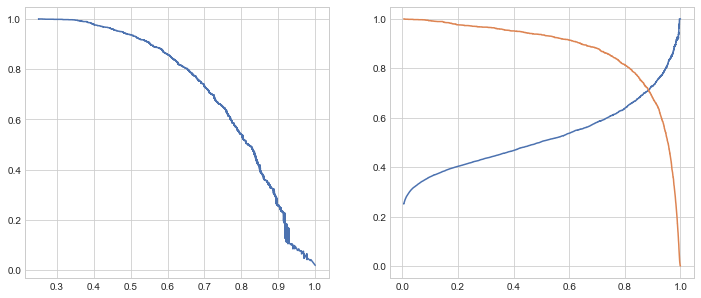

In [184]:
model_cat = catb.CatBoostClassifier(loss_function='Logloss',
                                verbose=True,
                                scale_pos_weight=20,
                                thread_count=20,
                                max_depth=4, 
                                learning_rate=0.1, 
                                n_estimators=1000,
                                reg_lambda=10,
                                   random_state=42)

df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

In [18]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=3,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=100,
                    verbosity=2,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg)

[15:26:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:14] INFO: /workspace/src/tree/upd

[15:27:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:58] INFO: /workspace/src/tree/upd

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0.0, max_depth=3,
              min_child_weight=0.0, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=20, nthread=20, num_parallel_tree=1,
              random_state=1337, reg_alpha=100.0, reg_lambda=1.0,
              scale_pos_weight=20.0, seed=1337, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=2)

# Reduce dataframe to most important features

In [185]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:100, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [186]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [187]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

In [188]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [189]:
def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
    plt.figure(figsize=(16,9))
    plt.plot(MONTH_NAMES, precision_scores)
    plt.plot(MONTH_NAMES, recall_scores)
    plt.plot(MONTH_NAMES, f1_scores)
    plt.legend(["precision", "recall", "f1-score"])

In [190]:
def get_best_model_through_CV(model, parameters_CV):
    # Fit model
    model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
    model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
                 df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
    print(model_CV.best_params_)
    
    # Predict and optimize threshold
    best_model = model_CV.best_estimator_
    df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
    # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print model evaluation scores
    
    df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
    display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
    precision_scores, recall_scores, f1_scores = [], [], []
    for month in range(1,12+1):
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)

    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
    return best_model, best_threshold_ERA

In [191]:
from sklearn.model_selection import cross_validate

def train_model_for_each_month(model, parameters):
    models_retrained_list, thresholds_list = [], []
    
    precision_scores, recall_scores, f1_scores = [], [], []
    
    plt.figure(figsize=(16,9))
    for month in range(1,12+1):
        # Define train and test masks
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
        # CV
#         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
#         print(model.get_params())
        model_CV = GridSearchCV(model, parameters, cv=[(slice(None), slice(None))], n_jobs=4, scoring=custom_metric_for_month, verbose=1)
        model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
                     df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])
        print(model_CV.cv_results_["mean_test_score"])
        # Get feature importance
#         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
        # Optimize threshold
        best_model = model_CV.best_estimator_
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
        display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
        # Retrain model on full data
        best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
                       df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
        models_retrained_list.append(best_model)
        thresholds_list.append(best_threshold_ERA)
        
    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    return models_retrained_list, thresholds_list

In [192]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# from sklearn.metrics import log_loss, make_scorer
def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix, ERA_len, CESM_len, alpha=100000):
    y = dtrain.get_label()[:ERA_len]
    
    pred = sigmoid(predt)
    pred_ERA = pred[:ERA_len]
    pred_CESM = pred[ERA_len:]
    
    grad_logloss  = pred_ERA - y
    hess_logloss = pred_ERA*(1.0 - pred_ERA)

    
#     grad = () + 2*alpha/CESM_len*(np.mean(predt) - np.mean(y))
    
    grad_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y))
    hess_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*((1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y)) -
                                                            pred_CESM*(np.mean(pred_CESM)-np.mean(y)) +
                                                            pred_CESM*(1-pred_CESM)/CESM_len
                                                            )
    
    grad = np.zeros(len(predt))
    grad[:ERA_len] = grad_logloss
    grad[ERA_len:] = grad_custom
    
    hess = np.zeros(len(predt))
    hess[:ERA_len] = hess_logloss
    hess[ERA_len:] = hess_custom
    
    return grad, hess

def custom_metric_for_month(estimator, X, y):
    month_mask_ERA_custom_metric = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_CESMp_custom_metric = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
    
    prediction_probas_ERA = estimator.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y, prediction_probas_ERA)
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]                                                         
    
    foehn_truth = df_ERA_reduced_features_scaled.loc[month_mask_ERA_custom_metric, "Foehn"]
    CESMp_predictions = (estimator.predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp_custom_metric, feature_names_reduced]) >best_threshold_ERA).astype(int)
    
    
    
    
    return -np.square(np.mean(CESMp_predictions)-np.mean(foehn_truth))

In [ ]:
monthly_models = 1
estimator = "XGB" # XGB, CATB, LGB, or KNN

## XGBoost estimator
if estimator == "XGB":
#     model = xgb.XGBClassifier(
#                     gamma=0.0,
#                     min_child_weight=0.0,
#                     max_delta_step=0.0,
#                     subsample=1.0,
#                     colsample_bytree=1.0,
#                     colsample_bylevel=1.0,
#                     verbosity=3,
#                     nthread=5,
#                     scale_pos_weight=20.0,
#                     base_score=0.2,
#                     seed=1337,
#                     missing=None,
#                     objective=custom_loss
#                   )
    parameters = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators':[30], "reg_alpha":[10], "reg_lambda":[10] }
    params = {'max_depth': 4, 'learning_rate': 0.1, "reg_alpha":10, "reg_lambda":10, "nthreads": 20, "n_jobs": 20,"verbosity":0, "seed": 0}
    
    models_retrained_list, thresholds_list = [], []
    for month in range(1,12+1):
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month = test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
        
        df_ERA_CESMp = pd.concat([df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced + ["Foehn"]], 
                                  df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced]],
                                axis=0)
        print(len(df_ERA_CESMp))
        
        D_train = xgb.DMatrix(df_ERA_CESMp[feature_names_reduced],
                             label=df_ERA_CESMp["Foehn"])
        model = xgb.Booster(params, [D_train])
        
        for _ in range(200):
            pred = model.predict(D_train)
            g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
            model.boost(D_train, g, h)
        
        D_test = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[test_mask_month, feature_names_reduced])
        yhat = sigmoid(model.predict(D_test))
        print(yhat)
        df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"] = sigmoid(model.predict(D_test))
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
#         print(model.get_score(importance_type='weight'))
        display(pd.DataFrame.from_dict(model.get_score(importance_type='weight'), orient="index", columns=["importance"]).sort_values(by="importance", ascending=False).head(10))
        
        
#         precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
#                                                                  yhat)
#         best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
# #         df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
# #         Plot model evaluation curves
#         f = plt.figure(figsize=(12,5))
#         f.add_subplot(121)
#         sns.lineplot(precisions, recalls)
#         f.add_subplot(122)
#         sns.lineplot(np.append(thresholds, 1.0), precisions)
#         sns.lineplot(np.append(thresholds, 1.0), recalls)
        
        models_retrained_list.append(model)
        thresholds_list.append(best_threshold_ERA)

In [193]:
        


    
## CatBoost estimator
elif estimator == "CGB":
    model = catb.CatBoostClassifier(loss_function='Logloss',
                                    verbose=False,
                                    scale_pos_weight=20,
                                    thread_count=5,
                                    random_seed=42)

    parameters = {'max_depth': [1,2,3,4, 5], 'learning_rate': [0.1], 'n_estimators':[10,20,30, 40,50, 100]}

## LightGBM estimator
elif estimator == "LGB":
    model = lgb.LGBMClassifier(loss_function='Logloss',
                               boosting_type="goss",
                                    verbose=0,
                                    scale_pos_weight=20,
                                    n_jobs=5,
                                    random_seed=42)

    parameters = {'max_depth': [1,2,3,4, 5], 'learning_rate': [0.1], 'n_estimators':[10,20,30, 40,50, 100]}

## KNN estimator
elif estimator == "KNN": 
    model = sklearn.neighbors.KNeighborsClassifier(n_jobs=8,weights="distance")
    parameters = {'n_neighbors': [30,50]}
elif estimator=="LR":
    model = sklearn.linear_model.LogisticRegression(random_state=42,class_weight={0:1, 1:20}, max_iter=500, n_jobs=30, penalty="l1", solver="saga")
    parameters= {"C":[0.1]}

# Monthly or yearly model
# if monthly_models:
#     models_retrained_list, thresholds_list = train_model_for_each_month(model, parameters)
# else:
#     model, best_threshold_ERA = get_best_model_through_CV(model, parameters)
#     model.set_params(n_jobs=25)
    
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"

46749
[0.02486311 0.66478944 0.5156674  ... 0.40415987 0.5149456  0.3450371 ]
Best threshold: 0.47570595145225525
Precision: 0.5784313725490197
Recall: 0.5728155339805825
[[1093   43]
 [  44   59]]


,importance
diff_SLP_4382_625_sealevel_SLP_4476_625_sealevel,61
V_4759_1375_850,53
diff_PHIT_4570_1375_850_PHIT_4664_1375_850,42
diff_PHIT_4664_1375_850_PHIT_4759_1375_850,40
diff_SLP_4287_125_sealevel_SLP_4382_125_sealevel,39
DELTAPHI_4570_0_850,34
V_4476_875_850,31
diff_SLP_4570_250_sealevel_SLP_4664_375_sealevel,30
DELTAPHI_4476_1375_700,29
U_4476_500_850,29


42244
[0.0014846  0.00255566 0.00225864 ... 0.00149533 0.00401213 0.00143263]
Best threshold: 0.42237648367881775
Precision: 0.5892857142857143
Recall: 0.5857988165680473
[[894  69]
 [ 70  99]]


,importance
DELTAPHI_4382_625_850,65
U_4476_500_850,52
V_4476_625_700,47
diff_PHIT_4664_1375_850_PHIT_4759_1375_850,46
V_4476_875_850,43
V_4759_1375_850,42
V_4853_1250_850,40
DELTAPHI_4382_625_700,39
V_4476_625_850,39
diff_SLP_4287_625_sealevel_SLP_4382_625_sealevel,37


46748
[0.00080485 0.00099215 0.00204358 ... 0.00381224 0.01882184 0.00165672]
Best threshold: 0.45725783705711365
Precision: 0.7431192660550459
Recall: 0.7408536585365854
[[828  84]
 [ 85 243]]


,importance
DELTAPHI_4382_1000_700,44
DELTAPHI_4382_625_700,44
diff_SLP_4382_1000_sealevel_SLP_4382_1125_sealevel,42
V_4759_1375_850,42
diff_SLP_4382_625_sealevel_SLP_4476_625_sealevel,39
DELTAPHI_4476_1000_700,39
diff_PHIT_4382_500_850_PHIT_4476_750_850,37
U_4476_500_850,33
diff_PHIT_4664_1375_850_PHIT_4759_1375_850,33
V_4476_625_700,31


45120
[0.22192729 0.11637311 0.69668144 ... 0.00209109 0.00775261 0.00436459]
Best threshold: 0.42468953132629395
Precision: 0.7821782178217822
Recall: 0.7796052631578947
[[830  66]
 [ 67 237]]


,importance
diff_Z_4476_1125_850_Z_4759_1375_850,34
V_4476_625_700,33
diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,31
DELTAPHI_4476_1375_850,30
DELTAPHI_4382_625_700,29
diff_PHIT_4382_500_850_PHIT_4476_625_850,28
diff_SLP_4476_875_sealevel_SLP_4853_875_sealevel,27
V_4759_1375_850,26
diff_Z_4570_1375_850_Z_4664_375_850,25
V_4476_875_850,24


46624
[0.0042573  0.00281038 0.00558801 ... 0.04042579 0.86248666 0.86438674]
Best threshold: 0.4088963270187378
Precision: 0.7605633802816901
Recall: 0.7570093457943925
[[975  51]
 [ 52 162]]


,importance
DELTAPHI_4853_1000_700,38
diff_SLP_4287_500_sealevel_SLP_4382_625_sealevel,34
diff_PHIT_4476_750_850_PHIT_4853_1250_850,31
U_4947_750_700,30
diff_SLP_4853_1125_sealevel_SLP_4947_1125_sealevel,30
V_4476_875_850,29
diff_SLP_4570_250_sealevel_SLP_4664_375_sealevel,28
DELTAPHI_4853_875_700,27
V_4476_1125_850,27
diff_SLP_4287_125_sealevel_SLP_4382_125_sealevel,27


45120
[0.02691217 0.00671127 0.04530223 ... 0.00316064 0.02976891 0.03080269]
Best threshold: 0.39640820026397705
Precision: 0.6919191919191919
Recall: 0.6884422110552764
[[940  61]
 [ 62 137]]


,importance
diff_Z_4287_0_700_Z_4476_125_700,64
DELTAPHI_4570_250_850,46
diff_SLP_4382_625_sealevel_SLP_4476_625_sealevel,43
DELTAPHI_4382_625_850,39
diff_PHIT_4476_750_850_PHIT_4476_875_850,39
diff_SLP_4570_250_sealevel_SLP_4664_375_sealevel,38
diff_PHIT_4476_500_850_PHIT_4476_625_850,38
diff_Z_4476_500_850_Z_4476_750_850,36
diff_PHIT_4570_1375_850_PHIT_4664_1375_850,36
diff_Z_4664_375_700_Z_4853_1375_700,35


46624
[0.0084835  0.00216752 0.00488447 ... 0.00846401 0.02547593 0.01523844]
Best threshold: 0.4658493101596832
Precision: 0.6797385620915033
Recall: 0.6753246753246753
[[1037   49]
 [  50  104]]


,importance
diff_Z_4570_1375_850_Z_4664_1375_850,58
V_4476_625_850,41
DELTAPHI_4853_1000_700,39
DELTAPHI_4287_1000_700,39
DELTAPHI_4853_1000_850,38
diff_SLP_4287_625_sealevel_SLP_4382_500_sealevel,33
diff_Z_4287_0_700_Z_4476_125_700,33
diff_SLP_4287_125_sealevel_SLP_4382_125_sealevel,31
V_4759_1375_850,30
DELTAPHI_4382_625_700,29


46624
[0.00922747 0.01395547 0.7477098  ... 0.0017023  0.007      0.08972813]
Best threshold: 0.451368510723114
Precision: 0.65
Recall: 0.6435643564356436
[[1104   35]
 [  36   65]]


,importance
DELTAPHI_4382_625_850,42
diff_SLP_4476_1125_sealevel_SLP_4476_1250_sealevel,39
U_4476_500_850,33
diff_SLP_4287_500_sealevel_SLP_4382_625_sealevel,31
diff_PHIT_4476_500_850_PHIT_4476_625_850,31
DELTAPHI_4382_625_700,29
diff_PHIT_4476_750_850_PHIT_4853_1500_850,29
diff_SLP_4570_250_sealevel_SLP_4664_375_sealevel,29
V_4476_1000_850,28
diff_SLP_4853_1125_sealevel_SLP_4947_1125_sealevel,27


45120
[0.00109822 0.00116986 0.00167366 ... 0.00438035 0.0089447  0.00254697]
Best threshold: 0.2542474865913391
Precision: 0.6732673267326733
Recall: 0.6666666666666666
[[1065   33]
 [  34   68]]


,importance
diff_SLP_4382_625_sealevel_SLP_4476_625_sealevel,46
diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,43
diff_PHIT_4382_500_850_PHIT_4476_500_850,39
V_4759_1375_850,35
diff_SLP_4287_375_sealevel_SLP_4382_375_sealevel,32
diff_SLP_4287_750_sealevel_SLP_4382_625_sealevel,31
diff_PHIT_4476_500_850_PHIT_4476_625_850,29
DELTAPHI_4287_1000_700,28
DELTAPHI_4853_1000_850,26
diff_SLP_4476_1125_sealevel_SLP_4476_1250_sealevel,25


46616
[0.01040168 0.00555414 0.00779145 ... 0.00444343 0.01188137 0.01607374]
Best threshold: 0.3923923075199127
Precision: 0.5897435897435898
Recall: 0.5822784810126582
[[1129   32]
 [  33   46]]


,importance
DELTAPHI_4287_1250_850,45
V_4759_1375_850,40
diff_SLP_4287_625_sealevel_SLP_4382_625_sealevel,35
V_4476_625_850,33
diff_SLP_4287_750_sealevel_SLP_4382_625_sealevel,29
DELTAPHI_4853_1000_850,28
diff_SLP_4287_125_sealevel_SLP_4382_125_sealevel,27
V_4476_1000_850,26
DELTAPHI_4476_1125_700,20
DELTAPHI_4382_625_850,18


45120
[0.00332541 0.00451169 0.00355091 ... 0.00168665 0.00291697 0.00293565]
Best threshold: 0.3965652287006378
Precision: 0.5642857142857143
Recall: 0.5602836879432624
[[998  61]
 [ 62  79]]


,importance
V_4476_875_850,41
V_4759_1375_850,40
U_4947_750_700,33
diff_PHIT_4476_750_850_PHIT_4853_1000_850,32
V_4476_625_850,28
DELTAPHI_4287_1000_700,27
diff_PHIT_4476_1000_850_PHIT_4853_1250_850,27
diff_Z_4382_1250_850_Z_4382_1500_850,27
DELTAPHI_4287_1250_850,25
diff_PHIT_4664_1375_850_PHIT_4759_1375_850,24


46624
[0.00377429 0.00857692 0.00737675 ... 0.46372616 0.14161839 0.01342722]
Best threshold: 0.45775970816612244
Precision: 0.6818181818181818
Recall: 0.6766917293233082
[[1065   42]
 [  43   90]]


,importance
diff_SLP_4570_250_sealevel_SLP_4664_375_sealevel,37
V_4476_625_700,37
diff_SLP_4382_625_sealevel_SLP_4476_625_sealevel,37
diff_PHIT_4664_1375_850_PHIT_4853_1125_850,36
V_4759_1375_850,34
diff_SLP_4287_125_sealevel_SLP_4382_125_sealevel,34
DELTAPHI_4476_1375_850,33
V_4476_625_850,30
DELTAPHI_4476_1000_700,30
diff_PHIT_4570_1375_850_PHIT_4664_1375_850,28


# Predict on CESMp and CESMf

In [194]:
if monthly_models:
    for month in range(1,12+1):
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
        month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )
        
        xgb_CESMp = xgb.DMatrix(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMp))
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)
        
        xgb_CESMf = xgb.DMatrix(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMf))
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
else:
    df_CESMp_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMp_reduced_features_scaled["prediction"] = (df_CESMp_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
    df_CESMf_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMf_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMf_reduced_features_scaled["prediction"] = (df_CESMf_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)

df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [195]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [196]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled, 
                                      df_CESMp_reduced_features_scaled, 
                                      df_CESMf_reduced_features_scaled], 
                                     axis=0, 
                                     ignore_index=True)

In [197]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [198]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [199]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [200]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

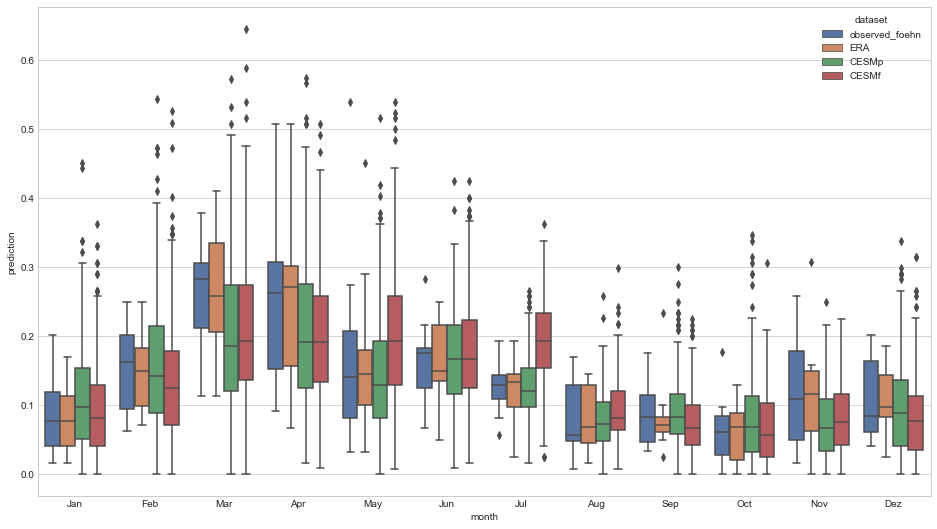

In [201]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);

# Second statistical test

(0.0, 0.5)

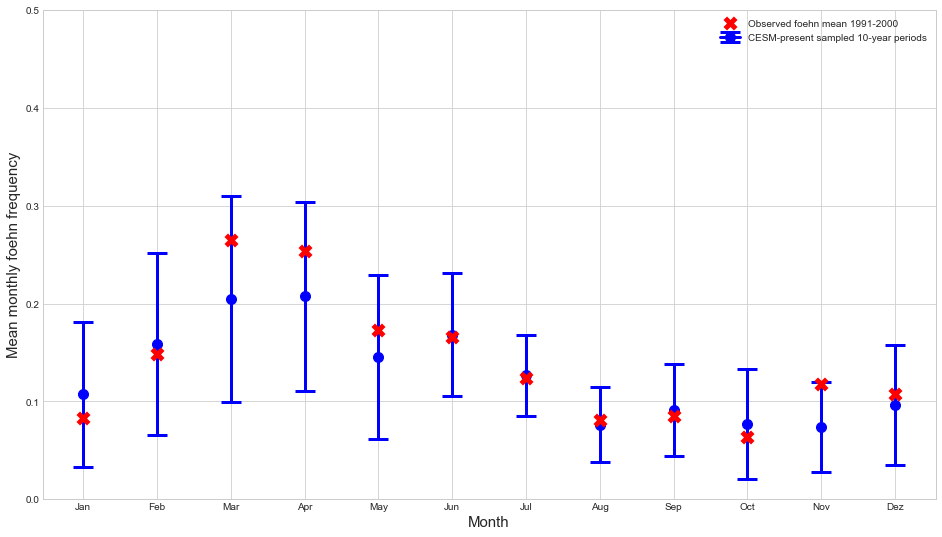

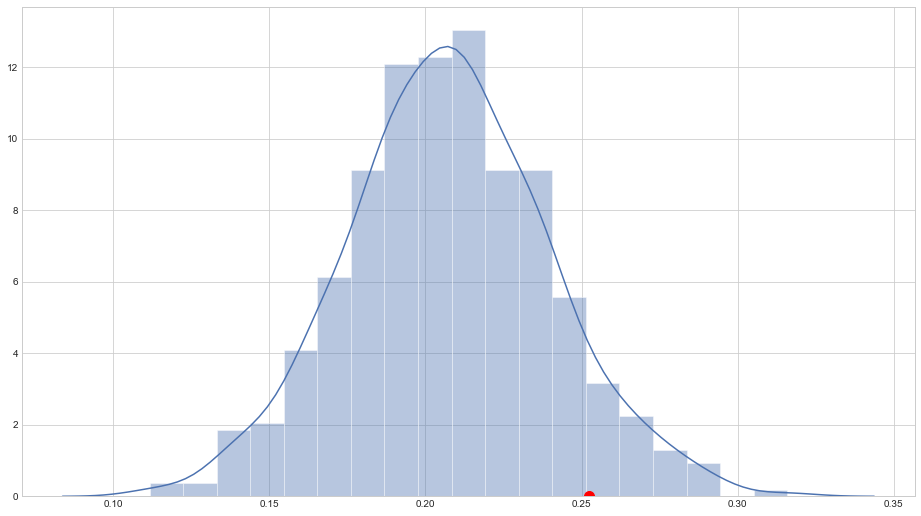

In [202]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["Observed foehn mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.50))


# Third statistical test

In [203]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.02585	False
Feb	0.07352	False
Mar	0.2489	False
Apr	0.74445	False
May	0.0	True
Jun	0.80424	False
Jul	0.0	True
Aug	0.00064	True
Sep	0.00156	True
Oct	0.15287	False
Nov	0.15287	False
Dez	0.01634	False


# Ensemble deviation

Text(0, 0.5, 'Mean monthly foehn prediction')

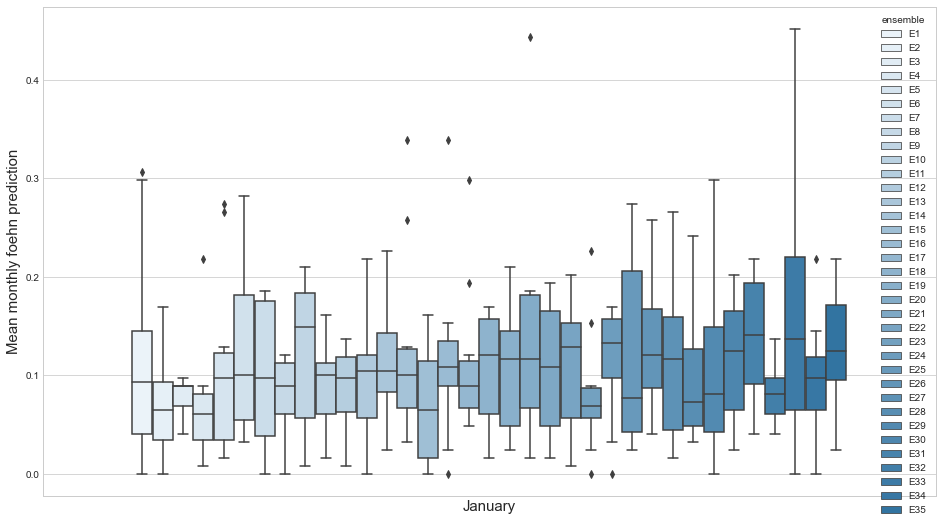

In [204]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
# sns.set(font_scale=0.8)

# Plot weathermaps

In [206]:
df_ERA_with_stability = calculate_stability(df = df_ERA_raw.drop(columns=["date"])+273.15, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)
df_ERA_with_stability["date"] = df_ERA_raw["date"]

Change2
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_temp
Change_t

In [207]:
variable = 'DELTAPHI'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "$^\circ$C",
        "DELTAPHI": "$^\circ$C",
        "U": "m/s",
        "V": "m/s"}

v_limits = {"SLP": [1013, 1025],#[1003, 1018],
            "Z": [1460, 1530],#[1350, 1520],
            "T": [17, 23],
            "DELTAPHI": [6,11],
            "U":[5,15],
            "V":[5,15]}

In [ ]:
plot_mean_foehn_condition_for_one_model(variable=variable, 
                                        variable_lvl = variable_lvl[variable] , 
                                        unit = unit[variable], 
                                        model= "OBS_NorthFoehn", 
                                        vmin = v_limits[variable][0], 
                                        vmax = v_limits[variable][1], 
                                        df = df_ERA_with_stability, 
                                        foehn = df_ERA_with_stability["Foehn"], 
                                        lats_labels = LATS_CESM_STRING, 
                                        lons_labels = LONS_CESM_STRING)

plot_mean_foehn_condition_for_one_model(variable=variable, 
                                        variable_lvl = variable_lvl[variable] , 
                                        unit = unit[variable], 
                                        model= "ERA_NorthFoehn", 
                                        vmin = v_limits[variable][0], 
                                        vmax = v_limits[variable][1], 
                                        df = df_ERA_with_stability, 
                                        foehn = df_ERA_reduced_features_scaled["prediction"], 
                                        lats_labels = LATS_CESM_STRING, 
                                        lons_labels = LONS_CESM_STRING)


plot_mean_foehn_condition_for_one_model(variable=variable, 
                                        variable_lvl = variable_lvl[variable] , 
                                        unit = unit[variable], 
                                        model= "CESMp_NorthFoehn", 
                                        vmin = v_limits[variable][0], 
                                        vmax = v_limits[variable][1], 
                                        df = df_CESMp, 
                                        foehn = df_CESMp_reduced_features_scaled["prediction"], 
                                        lats_labels = LATS_CESM_STRING, 
                                        lons_labels = LONS_CESM_STRING)

plot_mean_foehn_condition_for_one_model(variable=variable, 
                                        variable_lvl = variable_lvl[variable] , 
                                        unit = unit[variable], 
                                        model= "CESMf_NorthFoehn", 
                                        vmin = v_limits[variable][0], 
                                        vmax = v_limits[variable][1], 
                                        df = df_CESMf, 
                                        foehn = df_CESMf_reduced_features_scaled["prediction"], 
                                        lats_labels = LATS_CESM_STRING, 
                                        lons_labels = LONS_CESM_STRING)

/home/chmony/Apps/anaconda3/envs/develop_xgboost/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/chmony/Apps/anaconda3/envs/develop_xgboost/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_OBS_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_ERA_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_DELTAPHI_700_CESMp_NorthFoehn.pdf'
